In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import eurostat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import os
from airports import airport_data

# Getting the Data

in the following section are methods to get the data from the eurostat api and filter it

In [3]:
### CONSTANTS

# Columns that identify the data
ID_COLS = ["freq", "unit", "tra_meas", "airp_pr\\TIME_PERIOD"]

# Minimum fraction of non-NaN values required to keep a row
FRACTION_NON_NAN = 0

### List of the countries, EU + Switzerland, UK, Iceland, Norway, outcommented candidate countries
avia_par_countries = [
    "be",
    "bg",
    "dk",
    "de",
    "ee",
    "ie",
    "el",
    "es",
    "fr",
    "hr",
    "it",
    "cy",
    "lv",
    "lt",
    "lu",
    "hu",
    "mt",
    "nl",
    "at",
    "pl",
    "pt",
    "ro",
    "si",
    "sk",
    "fi",
    "se",
    "is",
    "no",
    "ch",
    "uk",
    # "ba", Candidate countries with incomplete data
    # "me",
    # "mk",
    # "rs",
    # "tr",
]

In [4]:
USE_CACHED_DATABASE = True

def get_data_df_cached(country):
    if USE_CACHED_DATABASE:
        if not os.path.exists("cache"):
            os.makedirs("cache")
        cache_file = f"cache/avia_par_{country}.pickle"
        if os.path.exists(cache_file):
            print(f"Loading cached data for {country}...")
            return pd.read_pickle(cache_file)
        else:
            print(f"No cached data found for {country}.")
            df = eurostat.get_data_df(f"avia_par_{country}")
            df.to_pickle(cache_file)
            return df
    else:
        df = eurostat.get_data_df(f"avia_par_{country}")
        return df


The following method can be used to transcript the nodes to the names of the airports, e.g., for plotting

In [5]:
def airportcode_to_name(airport_code):
    try:
        airport_by_icao = airport_data.get_airport_by_icao(airport_code.split("_")[-1])
        return airport_by_icao[0]["airport"]
    except KeyError:
        return airport_code

In [6]:
## just to show the raw data
data = get_data_df_cached("de")
data.head(10)

Loading cached data for de...


,freq,unit,tra_meas,airp_pr\TIME_PERIOD,1993,1994,1995,1996,1997,1998,...,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2024-Q1,2024-Q2,2024-Q3,2024-Q4
0,A,FLIGHT,CAF_PAS,DE_ED00_DE_EDDB,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A,FLIGHT,CAF_PAS,DE_ED00_DE_EDDH,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A,FLIGHT,CAF_PAS,DE_ED00_DE_EDDT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A,FLIGHT,CAF_PAS,DE_EDDB_AE_OMAA,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A,FLIGHT,CAF_PAS,DE_EDDB_AL_LATI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,A,FLIGHT,CAF_PAS,DE_EDDB_AT_LOWS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,A,FLIGHT,CAF_PAS,DE_EDDB_AT_LOWW,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,A,FLIGHT,CAF_PAS,DE_EDDB_BE_EBBR,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,A,FLIGHT,CAF_PAS,DE_EDDB_BG_LBBG,284.0,601.0,228.0,317.0,295.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,A,FLIGHT,CAF_PAS,DE_EDDB_BG_LBSF,7.0,7.0,14.0,6.0,21.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def get_monthly_data(data, year):
    """Get monthly data for passenger traffic for a given year"""
    year_df = data[
        ID_COLS
        + data.columns[data.columns.str.match(rf"^{year}-\d\d", na=False)].tolist()
    ]

    print(f"cols: {year_df.keys().tolist()}")
    if year_df.shape[1] != 16:  ## 16 columns: 4 ID_COLS + 12 months
        raise ValueError(f"Expected 16 columns for year {year}, got {year_df.shape[1]}")
    year_m_pas_pasbrd = year_df[
        (year_df["unit"] == "PAS")
        & (year_df["freq"] == "M")
        & (year_df["tra_meas"] == "PAS_BRD")
    ]

    # 1. Select columns matching a regex (example: date columns)
    regex = r"^\d{4}"  # adjust as needed
    cols = year_m_pas_pasbrd.filter(regex=regex).columns

    # 2. Keep rows where more than half of those columns are non-NaN
    threshold = len(cols) * FRACTION_NON_NAN
    df_filtered = year_m_pas_pasbrd[
        year_m_pas_pasbrd[cols].notna().sum(axis=1) >= threshold
    ]
    print(
        f"Removed {year_m_pas_pasbrd.shape[0] - df_filtered.shape[0]} rows with insufficient data for year {year}"
    )
    print(f"Remaining rows: {df_filtered.shape[0]}")

    # sanity check. do all rows have an airport route according to parsable regex?
    if (
        not df_filtered["airp_pr\\TIME_PERIOD"]
        .str.match(r"^[A-Z]{2}_[A-Z]{2}.._[A-Z]{2}_[A-Z]{2}..$", na=False)
        .all()
    ):
        print(
            f"[WARNING]Not all rows have a valid airport route for year {year}: {df_filtered['airp_pr\\TIME_PERIOD'][~df_filtered['airp_pr\\TIME_PERIOD'].str.match(r'^[A-Z]{2}_[A-Z]{2}.._[A-Z]{2}_[A-Z]{2}..$', na=False)]}"
        )

    # are all rows unique according to airport route?
    if df_filtered["airp_pr\\TIME_PERIOD"].nunique() != df_filtered.shape[0]:
        raise ValueError(
            f"Not all rows are unique according to airport route for year {year}"
        )

    return df_filtered

In [8]:
## method to check whether more data is available on a monthly basis than yearly basis, not used for graph creation
def check_sum_monthly_eq_yearly(data, year):
    month_df = data[
        ID_COLS
        + data.columns[data.columns.str.match(rf"^{year}-\d\d", na=False)].tolist()
    ]

    print(f"cols: {month_df.keys().tolist()}")
    if month_df.shape[1] != 16:  ## 16 columns: 4 ID_COLS + 12 months
        raise ValueError(
            f"Expected 16 columns for year {year}, got {month_df.shape[1]}"
        )
    month_m_pas_pasbrd = month_df[
        (month_df["unit"] == "PAS")
        & (month_df["freq"] == "M")
        & (month_df["tra_meas"] == "PAS_BRD")
    ]

    year_df = data[
        ID_COLS + data.columns[data.columns.str.match(rf"^{year}$", na=False)].tolist()
    ]
    print(f"cols: {year_df.keys().tolist()}")

    year_m_pas_pasbrd = year_df[
        (year_df["unit"] == "PAS")
        & (year_df["freq"] == "M")
        & (year_df["tra_meas"] == "PAS_BRD")
    ]

    if year_m_pas_pasbrd.shape[0] != month_m_pas_pasbrd.shape[0]:
        raise ValueError(
            f"Yearly and monthly data have different number of rows for year {year}: {year_m_pas_pasbrd.shape[0]} vs {month_m_pas_pasbrd.shape[0]}"
        )

    sum_zero = 0
    year_nan = 0
    missmatch = 0
    for i, row in year_m_pas_pasbrd.iterrows():
        route = row["airp_pr\\TIME_PERIOD"]
        yearly_value = row[str(year)]
        monthly_values = month_m_pas_pasbrd[
            month_m_pas_pasbrd["airp_pr\\TIME_PERIOD"] == route
        ]
        if monthly_values.empty:
            raise ValueError(f"No monthly data for route {route} in year {year}")
        monthly_sum = (
            monthly_values.filter(regex=rf"^{year}-\d\d$").sum(axis=1).values[0]
        )
        if yearly_value != monthly_sum:
            missmatch += 1
            if not (pd.isna(yearly_value) or monthly_sum == 0 or pd.isna(monthly_sum)):
                raise ValueError(
                    f"Yearly value {yearly_value} does not match sum of monthly values {monthly_sum} for route {route} in year {year}"
                )
            else:
                if pd.isna(yearly_value):
                    year_nan += 1
                if monthly_sum == 0 or pd.isna(monthly_sum):
                    sum_zero += 1
    print(
        f"Checked {year_m_pas_pasbrd.shape[0]} routes for year {year}. Yearly NaNs: {year_nan}, Monthly sum NaNs: {sum_zero}, Mismatches: {missmatch}"
    )


check_sum_monthly_eq_yearly(data, 2015)

cols: ['freq', 'unit', 'tra_meas', 'airp_pr\\TIME_PERIOD', '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12']
cols: ['freq', 'unit', 'tra_meas', 'airp_pr\\TIME_PERIOD', '2015']
Checked 2032 routes for year 2015. Yearly NaNs: 2032, Monthly sum NaNs: 1149, Mismatches: 2032


from the results we can see that if there are missmatches between the monthly data and the yearly, the monthly seems more accurate

# Network Building

now we build a network using the methods from above

In [9]:
AGGREGATE = True ### Use aggregated months for edge weights
INVERSE_WEIGHT = False ### set to true to use inverse of passenger count as edge weight (more similar to distances)
USE_CACHED_GRAPH = False ### Use cached graph if available. Maybe don't use this option but instead the cached database above

In [ ]:
## Create graph for year 2015 for testing. Plot the graph with distances according to passenger counts
G_TEST = nx.DiGraph()

def add_to_graph(graph, df):
    for _, row in df.iterrows():
        first = "_".join(row['airp_pr\\TIME_PERIOD'].split("_", 2)[:2])
        second = "_".join(row['airp_pr\\TIME_PERIOD'].split("_", 2)[2:])
        if AGGREGATE:
            amount = row.filter(regex=r'^\d{4}-\d\d$').sum()
            if amount == 0 or pd.isna(amount):
                continue
            else:
                weight = 1 / amount if INVERSE_WEIGHT else amount
        else:
            raise NotImplementedError("Non-aggregate mode not implemented yet, scusi")

        # skip edges with no meaningful weight to reduce clutter
        if pd.isna(weight) or weight == 0:
            continue

        graph.add_edge(first, second, weight=weight)

d1 = get_monthly_data(data, 2015)
d1.head(10)
print(d1.shape)

add_to_graph(G_TEST, d1)

# compute positions for all nodes once to avoid "no position" errors
pos = nx.kamada_kawai_layout(G_TEST)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# nx.draw expects a single Axes object, not an array -> use ax[0]
nx.draw(G_TEST, pos=pos, ax=ax, with_labels=True, font_weight='bold', node_size=50, font_size=8, edge_color='gray')

plt.show()

NameError: name 'd1' is not defined

In [ ]:
## Here, the main action happens. We iterate over countries and years to build the graphs. the graphs are then stored into a dictionary as G_YYYY
years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
no_graphs_years = []
graphs = {}
for year in years:
    if USE_CACHED_GRAPH and f"G_{year}.pickle" in os.listdir():
        print("Using cached graph.")
        graphs[f"G_{year}"] = pickle.load(open(f"G_{year}.pickle", 'rb'))
        print(f"Graph has {graphs[f"G_{year}"].number_of_nodes()} nodes and {graphs[f"G_{year}"].number_of_edges()} edges.")
    else:
        no_graphs_years.append(year)

if no_graphs_years:
    print(f"Constructing graphs for years: {no_graphs_years}")
    for i, country in enumerate(avia_par_countries):
        print(f"Processing country: {country} ({i + 1}/{len(avia_par_countries)})")
        print("loading data...")
        c_df = get_data_df_cached(country)
        print("filtering data...")
        for year in no_graphs_years:
            if year >= 2020 and country == "uk":
                print(f"Skipping year {year} for country {country} due to missing data after brexit")
                continue
            print(f"Processing year: {year}")
            if f"G_{year}" not in graphs:
                print(f"Creating graph for year {year}...")
                graphs[f"G_{year}"] = nx.DiGraph()
            G_current = graphs[f"G_{year}"]
            monthly_data = get_monthly_data(c_df, year)
            print(f"adding to graph G_{year}...")
            add_to_graph(G_current, monthly_data)
            print("G_current now has "
                  f"{G_current.number_of_nodes()} nodes and {G_current.number_of_edges()} edges.")
        print(f"------------------------------------------------------------")
    for year in no_graphs_years:
        pickle.dump(graphs[f"G_{year}"], open(f"G_{year}.pickle", 'wb'))
        print(f"Graph saved to G_{year}.pickle")
        print(f"Graph has {graphs[f"G_{year}"].number_of_nodes()} nodes and {graphs[f"G_{year}"].number_of_edges()} edges.")



Constructing graphs for years: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Processing country: be (1/30)
loading data...
Loading cached data for be...
filtering data...
Processing year: 2014
Creating graph for year 2014...
cols: ['freq', 'unit', 'tra_meas', 'airp_pr\\TIME_PERIOD', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12']
Removed 0 rows with insufficient data for year 2014
Remaining rows: 301
adding to graph G_2014...
G_current now has 121 nodes and 158 edges.
Processing year: 2015
Creating graph for year 2015...
cols: ['freq', 'unit', 'tra_meas', 'airp_pr\\TIME_PERIOD', '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12']
Removed 0 rows with insufficient data for year 2015
Remaining rows: 301
adding to graph G_2015...
G_current now has 128 nodes and 168 edges.
Processing year: 2016
Creating graph

In [ ]:
## short sanity check of created graph: watch out that all edges are different :)
G = graphs["G_2024"]
for u,v,d in G.edges(data=True):
    print(f"Edge from {u} to {v} with weight {d['weight']}")
print (f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")   

Edge from BE_EBAW to ES_GCTS with weight 17388.0
Edge from BE_EBAW to ES_LEAL with weight 43229.0
Edge from BE_EBAW to ES_LEMG with weight 37448.0
Edge from ES_GCTS to AT_LOWW with weight 193631.0
Edge from ES_GCTS to BE_EBBR with weight 342077.0
Edge from ES_GCTS to BE_EBCI with weight 103065.0
Edge from ES_GCTS to CH_LSZH with weight 125390.0
Edge from ES_GCTS to CZ_LKPR with weight 93504.0
Edge from ES_GCTS to DE_EDDB with weight 181228.0
Edge from ES_GCTS to DE_EDDF with weight 289225.0
Edge from ES_GCTS to DE_EDDH with weight 139099.0
Edge from ES_GCTS to DE_EDDK with weight 111499.0
Edge from ES_GCTS to DE_EDDL with weight 301245.0
Edge from ES_GCTS to DE_EDDM with weight 185508.0
Edge from ES_GCTS to DE_EDDN with weight 77384.0
Edge from ES_GCTS to DE_EDDS with weight 118230.0
Edge from ES_GCTS to DE_EDDV with weight 90274.0
Edge from ES_GCTS to DK_EKCH with weight 103598.0
Edge from ES_GCTS to ES_GCLP with weight 208115.0
Edge from ES_GCTS to ES_LEMD with weight 440082.0
Edge f

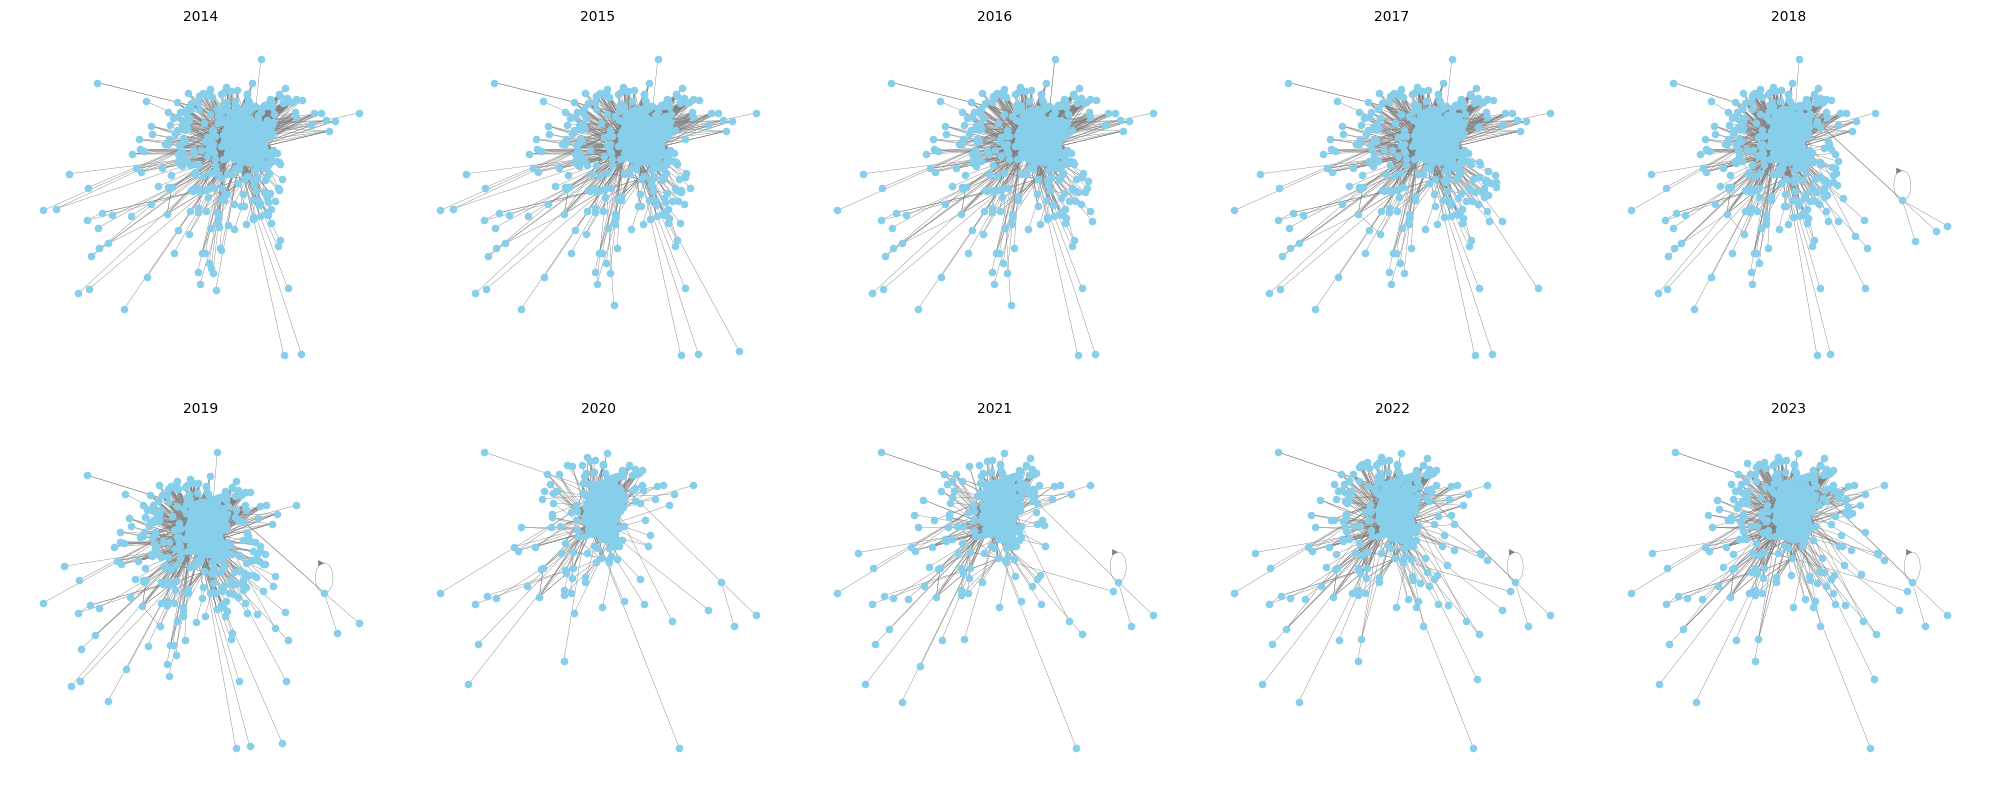

In [ ]:
# plot the first ten graphs from `graphs` in a 2x5 grid using a single Kamada-Kawai layout
keys = sorted(graphs.keys())[:10]  # first 10 graphs (e.g. 'G_2014'..)
graphs_to_plot = [graphs[k] for k in keys]

# compose a union graph so we compute a single global layout (same algorithm as above)
G_union = nx.compose_all(graphs_to_plot)
pos_all = nx.kamada_kawai_layout(G_union)

# create subplots (2 rows x 5 cols)
n = len(graphs_to_plot)
rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
axes_flat = axes.flatten()

# drawing parameters for compact visualization
node_size = 20
edge_width = 0.3
font_size = 6

for idx, (ax, key, G_i) in enumerate(zip(axes_flat, keys, graphs_to_plot)):
    nx.draw_networkx_nodes(G_i, pos_all, ax=ax, node_size=node_size, node_color="skyblue")
    nx.draw_networkx_edges(G_i, pos_all, ax=ax, width=edge_width, edge_color="gray", arrows=False)
    # skip labels to avoid clutter; enable if you need them by setting with_labels=True
    ax.set_title(key.split("_")[1], fontsize=10)
    ax.set_axis_off()

# turn off any unused subplots
for ax in axes_flat[n:]:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# Analisis

### Hubs and Authorities

Year: 2014
Top 3 Hubs:
  UK_EGLL: 0.052474
  FR_LFPG: 0.039655
  DE_EDDF: 0.038892
Top 3 Authorities:
  UK_EGLL: 0.024354
  DE_EDDF: 0.022186
  NL_EHAM: 0.021997
--------------------------------------------------
Year: 2015
Top 3 Hubs:
  UK_EGLL: 0.050054
  FR_LFPG: 0.038047
  DE_EDDF: 0.036719
Top 3 Authorities:
  UK_EGLL: 0.024086
  NL_EHAM: 0.022554
  ES_LEBL: 0.022337
--------------------------------------------------
Year: 2016
Top 3 Hubs:
  UK_EGLL: 0.046138
  FR_LFPG: 0.035339
  NL_EHAM: 0.035232
Top 3 Authorities:
  NL_EHAM: 0.023408
  ES_LEBL: 0.023301
  UK_EGLL: 0.022905
--------------------------------------------------
Year: 2017
Top 3 Hubs:
  UK_EGLL: 0.044471
  NL_EHAM: 0.035476
  FR_LFPG: 0.035011
Top 3 Authorities:
  NL_EHAM: 0.023724
  ES_LEBL: 0.022848
  ES_LEMD: 0.022182
--------------------------------------------------
Year: 2018
Top 3 Hubs:
  UK_EGLL: 0.042988
  NL_EHAM: 0.035130
  FR_LFPG: 0.034567
Top 3 Authorities:
  NL_EHAM: 0.023150
  ES_LEBL: 0.022840
  ES_L

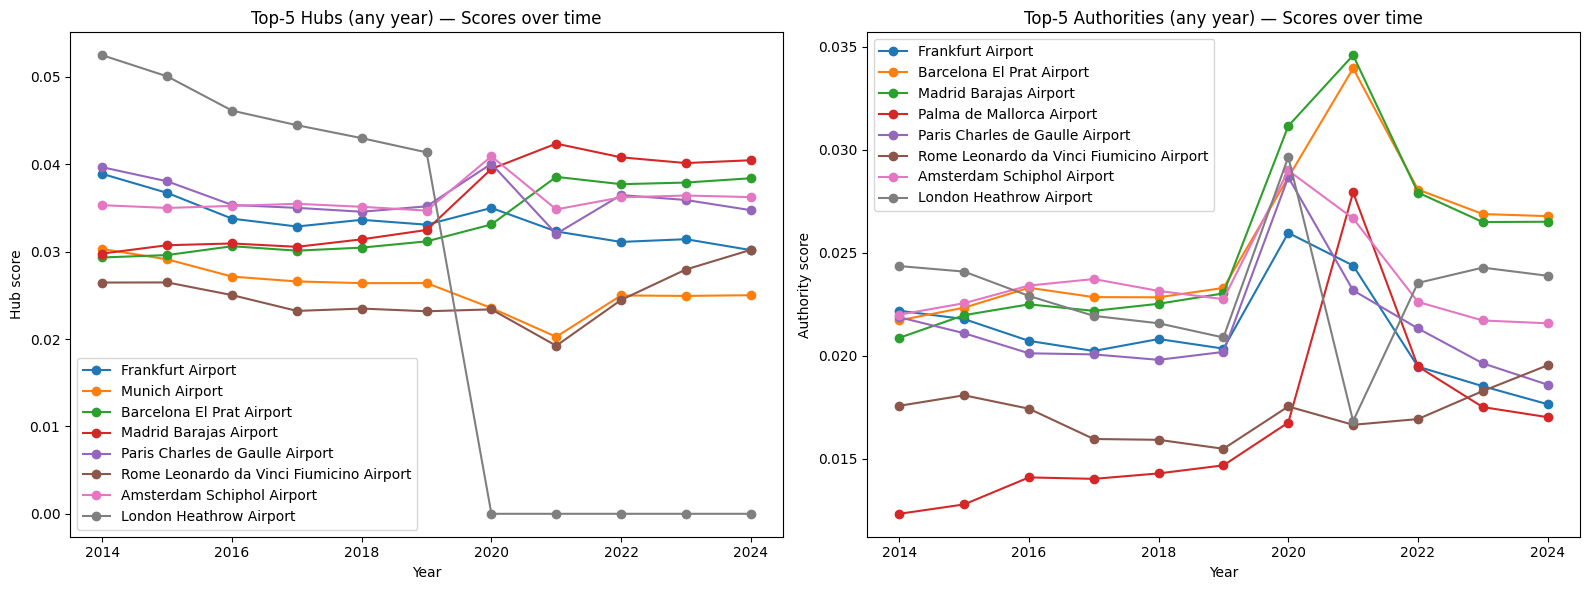

In [ ]:
hub_list = []
authorities_list = []

for graph in sorted(graphs.keys()):
    G_i = graphs[graph]
    hubs, authorities = nx.hits(G_i, max_iter=1000, normalized=True)
    hub_list.append(hubs)
    authorities_list.append(authorities)

### find top k hubs and authorities for each year
k = 3
for i, year in enumerate(sorted(graphs.keys())):
    print(f"Year: {year.split('_')[1]}")
    hubs = hub_list[i]
    authorities = authorities_list[i]
    top_hubs = sorted(hubs.items(), key=lambda x: x[1], reverse=True)[:k]
    top_authorities = sorted(authorities.items(), key=lambda x: x[1], reverse=True)[:k]
    print(f"Top {k} Hubs:")
    for node, score in top_hubs:
        print(f"  {node}: {score:.6f}")
    print(f"Top {k} Authorities:")
    for node, score in top_authorities:
        print(f"  {node}: {score:.6f}")
    print("--------------------------------------------------")
# collect union of top-5 hubs and authorities across all years
hubs_union = set()
auths_union = set()
for i in range(len(hub_list)):
    top_hubs = sorted(hub_list[i].items(), key=lambda x: x[1], reverse=True)[:5]
    top_auths = sorted(authorities_list[i].items(), key=lambda x: x[1], reverse=True)[:5]
    hubs_union.update(n for n, _ in top_hubs)
    auths_union.update(n for n, _ in top_auths)

# build time series only for those nodes
hub_scores = {node: [hub_list[i].get(node, 0) for i in range(len(hub_list))] for node in sorted(hubs_union)}
authority_scores = {node: [authorities_list[i].get(node, 0) for i in range(len(authorities_list))] for node in sorted(auths_union)}

# plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].set_title("Top-5 Hubs (any year) — Scores over time")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Hub score")
for node, scores in hub_scores.items():
    axes[0].plot(years, scores, marker='o', label=airportcode_to_name(node))
axes[0].legend()
axes[1].set_title("Top-5 Authorities (any year) — Scores over time")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Authority score")
for node, scores in authority_scores.items():
    axes[1].plot(years, scores, marker='o', label=airportcode_to_name(node))
axes[1].legend()

plt.tight_layout()
plt.show()

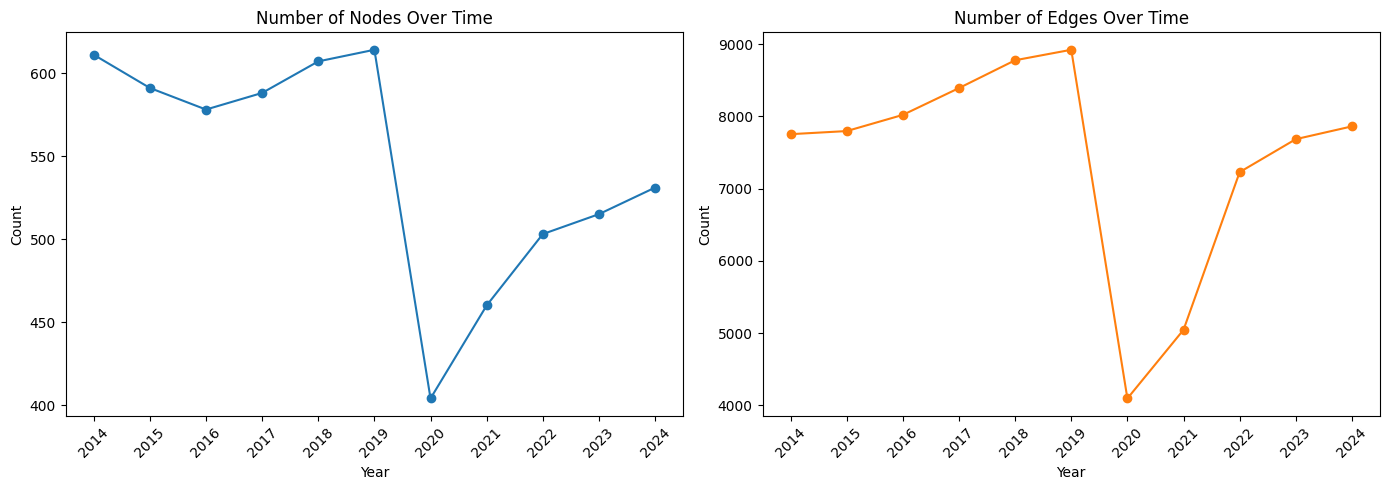

In [ ]:
# two separate plots side-by-side: nodes and edges over time
sorted_keys = sorted(graphs.keys())
years_numeric = [int(k.split("_")[1]) for k in sorted_keys]
num_nodes = [graphs[k].number_of_nodes() for k in sorted_keys]
num_edges = [graphs[k].number_of_edges() for k in sorted_keys]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(years_numeric, num_nodes, marker='o', color='C0')
ax1.set_title("Number of Nodes Over Time")
ax1.set_xlabel("Year")
ax1.set_ylabel("Count")
ax1.set_xticks(years_numeric)

ax2.plot(years_numeric, num_edges, marker='o', color='C1')
ax2.set_title("Number of Edges Over Time")
ax2.set_xlabel("Year")
ax2.set_ylabel("Count")
ax2.set_xticks(years_numeric)

for ax in (ax1, ax2):
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

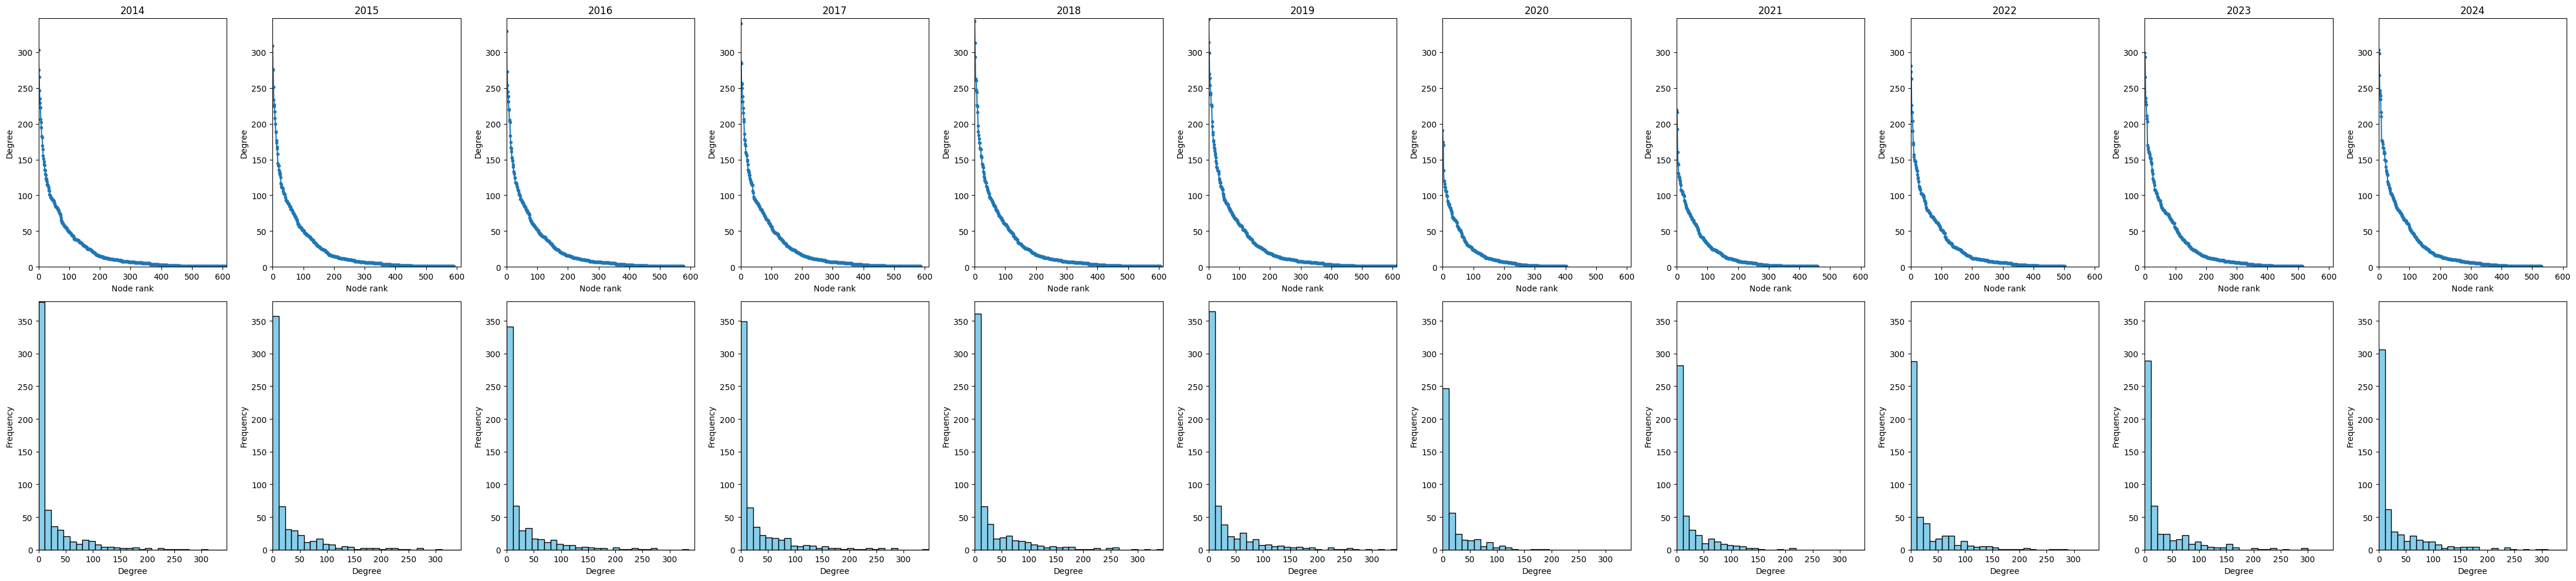

In [ ]:
# Degree rank and histogram with shared x/y limits across columns
sorted_keys = sorted(graphs.keys())
degrees = [sorted((d for n, d in graphs[k].degree()), reverse=True) for k in sorted_keys]

n = len(sorted_keys)
fig, axes = plt.subplots(2, n, figsize=(4 * n, 10))

# global limits
max_nodes = max((len(d) for d in degrees), default=1)
max_degree = max((max(d) if d else 0 for d in degrees), default=0)
if max_degree == 0:
    max_degree = 1  # avoid zero-range for hist/xlim

bins = 30
hist_counts = [np.histogram(d, bins=bins, range=(0, max_degree))[0] for d in degrees]
max_hist_count = max((hc.max() if len(hc) else 0 for hc in hist_counts), default=1)

for i, key in enumerate(sorted_keys):
    ax_rank = axes[0, i]
    ax_hist = axes[1, i]

    # Degree rank plot (shared x/y limits)
    ax_rank.plot(range(len(degrees[i])), degrees[i], marker='o', markersize=3)
    ax_rank.set_title(key.split("_")[1])
    ax_rank.set_xlabel("Node rank")
    ax_rank.set_ylabel("Degree")
    ax_rank.set_xlim(0, max_nodes - 1)
    ax_rank.set_ylim(0, max_degree + 1)

    # Degree histogram (use same bins/range and shared y limit)
    ax_hist.hist(degrees[i], bins=bins, range=(0, max_degree), color='skyblue', edgecolor='black')
    ax_hist.set_xlabel("Degree")
    ax_hist.set_ylabel("Frequency")
    ax_hist.set_xlim(0, max_degree)
    ax_hist.set_ylim(0, max_hist_count + 1)

plt.tight_layout()
plt.show()


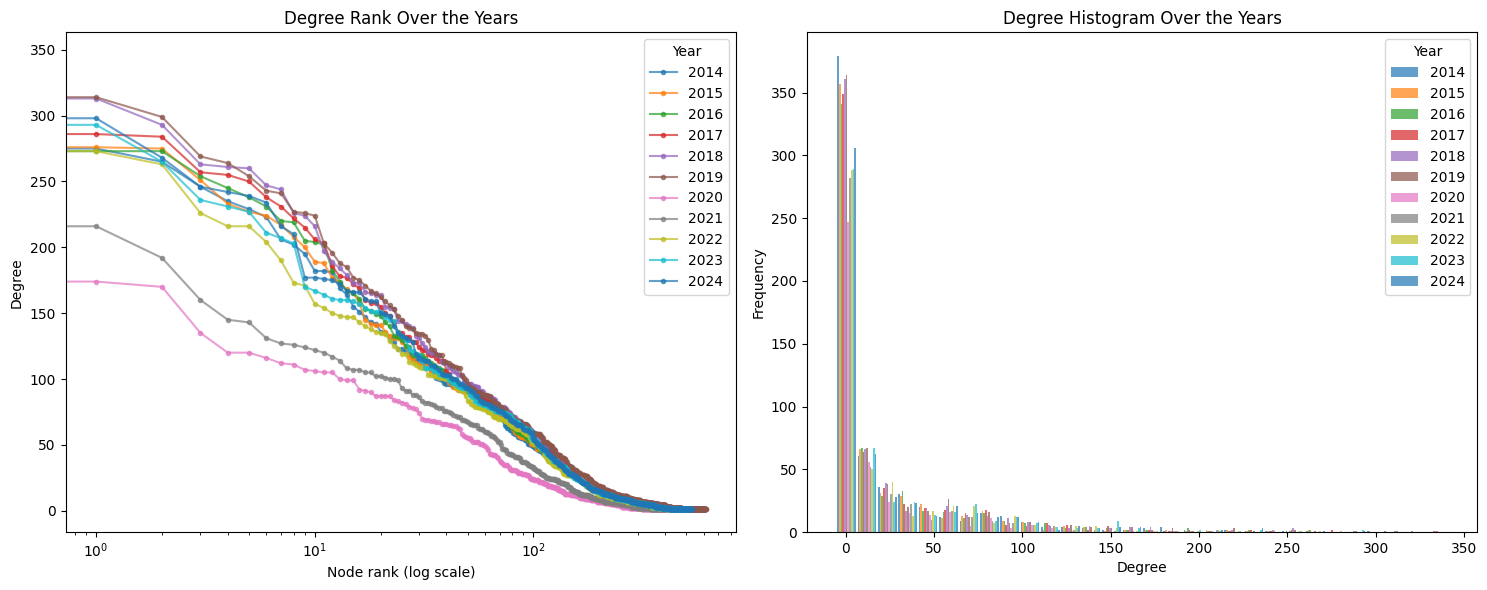

In [ ]:
# now the same but in a single plot per type
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# titles
axes[0].set_title("Degree Rank Over the Years")
axes[1].set_title("Degree Histogram Over the Years")

# log scale for x
axes[0].set_xscale('log')
for i, key in enumerate(sorted_keys):
    # Degree rank plot
    axes[0].plot(range(len(degrees[i])), degrees[i], marker='o', alpha=0.7, markersize=3, label=key.split("_")[1])

    # Degree histogram
    # compute histogram counts and draw shifted bars so they don't overlap
    counts, bin_edges = np.histogram(degrees[i], bins=bins, range=(0, max_degree))
    bin_width = bin_edges[1] - bin_edges[0]
    n_series = len(sorted_keys)
    # width for each year's bars inside a bin
    bar_width = bin_width / (n_series + 1)
    # center the group of bars on the bin by offsetting each year's bars
    offset = (i - (n_series - 1) / 2) * bar_width
    axes[1].bar(bin_edges[:-1] + offset, counts, width=bar_width, align='edge', alpha=0.7, label=key.split("_")[1])
axes[0].legend(title="Year")
axes[0].set_xlabel("Node rank (log scale)")
axes[0].set_ylabel("Degree")
axes[1].legend(title="Year")
axes[1].set_xlabel("Degree")
axes[1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

Year: 2014, Average Clustering Coefficient: 0.386417
Year: 2015, Average Clustering Coefficient: 0.401593
Year: 2016, Average Clustering Coefficient: 0.422848
Year: 2017, Average Clustering Coefficient: 0.432433
Year: 2018, Average Clustering Coefficient: 0.422168
Year: 2019, Average Clustering Coefficient: 0.412489
Year: 2020, Average Clustering Coefficient: 0.369717
Year: 2021, Average Clustering Coefficient: 0.358012
Year: 2022, Average Clustering Coefficient: 0.426372
Year: 2023, Average Clustering Coefficient: 0.427322
Year: 2024, Average Clustering Coefficient: 0.417727


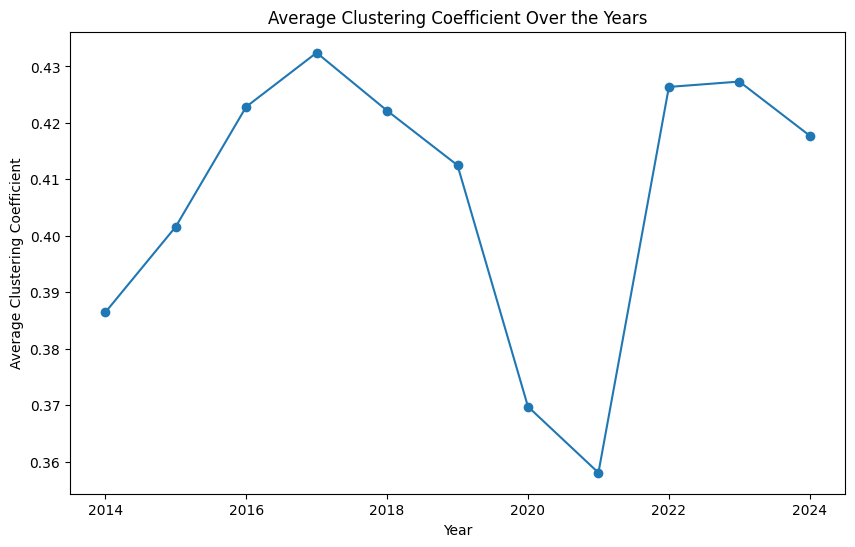

In [ ]:
# calculate average clustering coefficient for each year's graph
avg_clustering = {}
for key in sorted_keys:
    G_i = graphs[key]
    if G_i.number_of_nodes() == 0:
        avg_clustering[key] = 0
        print(f"Graph {key} has no nodes, setting average clustering to 0.")
        continue
    undirected_G = G_i.to_undirected()
    clustering_coeffs = nx.clustering(undirected_G)
    avg_coeff = sum(clustering_coeffs.values()) / len(clustering_coeffs)
    avg_clustering[key] = avg_coeff
    print(f"Year: {key.split('_')[1]}, Average Clustering Coefficient: {avg_coeff:.6f}")
# plot average clustering coefficient over the years
fig, ax = plt.subplots(figsize=(10, 6))
years_numeric = [int(key.split("_")[1]) for key in sorted_keys]
avg_coeffs = [avg_clustering[key] for key in sorted_keys]
ax.plot(years_numeric, avg_coeffs, marker='o')
ax.set_title("Average Clustering Coefficient Over the Years")
ax.set_xlabel("Year")
ax.set_ylabel("Average Clustering Coefficient")
plt.show()

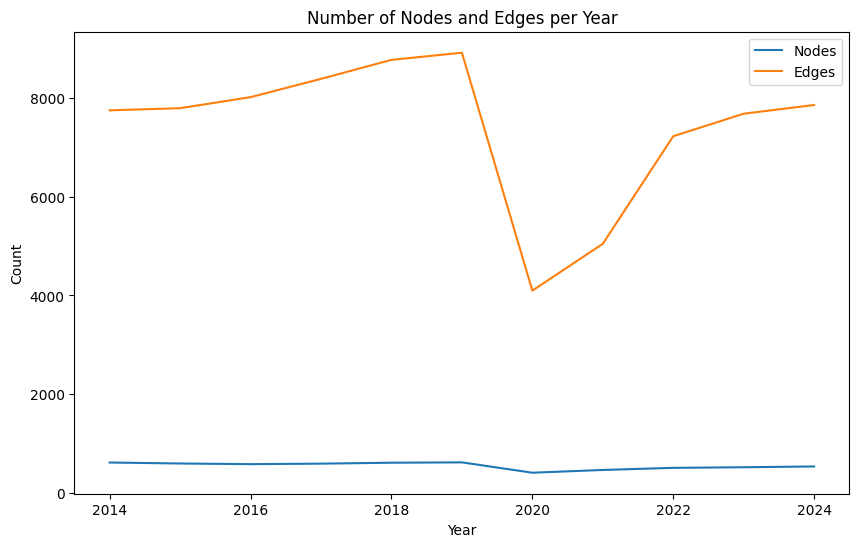

In [ ]:
#plot the number of nodes and edges per year

nodes = []
edges = []

fig, ax = plt.subplots(figsize=(10, 6))
for key in sorted_keys:
    G_i = graphs[key]
    nodes.append(G_i.number_of_nodes())
    edges.append(G_i.number_of_edges())

ax.plot(years, nodes, label="Nodes")
ax.plot(years, edges, label="Edges")

ax.set_xlabel("Year")
ax.set_ylabel("Count")
ax.set_title("Number of Nodes and Edges per Year")
ax.legend()
plt.show()


In [ ]:
## list the nodes with highes in and out degree for all years in a nice plot
top_k = 5
for key in sorted_keys:
    G_i = graphs[key]
    in_degrees = G_i.in_degree()
    out_degrees = G_i.out_degree()
    top_in = sorted(in_degrees, key=lambda x: x[1], reverse=True)[:top_k]
    top_out = sorted(out_degrees, key=lambda x: x[1], reverse=True)[:top_k]
    print(f"Year: {key.split('_')[1]}")
    print(f"Top {top_k} In-Degree Nodes:")
    for node, degree in top_in:
        print(f"  {node}: {degree}")
    print(f"Top {top_k} Out-Degree Nodes:")
    for node, degree in top_out:
        print(f"  {node}: {degree}")
    print("--------------------------------------------------")

Year: 2014
Top 5 In-Degree Nodes:
  UK_EGSS: 132
  NL_EHAM: 124
  UK_EGKK: 121
  ES_LEPA: 118
  ES_LEBL: 117
Top 5 Out-Degree Nodes:
  NL_EHAM: 179
  FR_LFPG: 170
  DE_EDDF: 169
  UK_EGLL: 143
  DE_EDDM: 126
--------------------------------------------------
Year: 2015
Top 5 In-Degree Nodes:
  NL_EHAM: 131
  UK_EGSS: 127
  UK_EGKK: 122
  ES_LEBL: 120
  ES_LEPA: 112
Top 5 Out-Degree Nodes:
  NL_EHAM: 178
  DE_EDDF: 173
  FR_LFPG: 172
  UK_EGLL: 143
  DE_EDDM: 129
--------------------------------------------------
Year: 2016
Top 5 In-Degree Nodes:
  NL_EHAM: 139
  UK_EGSS: 132
  ES_LEBL: 124
  IE_EIDW: 120
  DE_EDDM: 118
Top 5 Out-Degree Nodes:
  NL_EHAM: 190
  DE_EDDF: 173
  FR_LFPG: 169
  UK_EGLL: 147
  DE_EDDM: 136
--------------------------------------------------
Year: 2017
Top 5 In-Degree Nodes:
  NL_EHAM: 145
  UK_EGSS: 140
  UK_EGKK: 122
  ES_LEBL: 121
  IE_EIDW: 121
Top 5 Out-Degree Nodes:
  NL_EHAM: 195
  DE_EDDF: 180
  FR_LFPG: 176
  UK_EGLL: 149
  DE_EDDM: 139
---------------

Year: 2014, Nodes with In-Degree 0: 10, Nodes with Out-Degree 0: 309
Year: 2015, Nodes with In-Degree 0: 8, Nodes with Out-Degree 0: 291
Year: 2016, Nodes with In-Degree 0: 12, Nodes with Out-Degree 0: 273
Year: 2017, Nodes with In-Degree 0: 15, Nodes with Out-Degree 0: 285
Year: 2018, Nodes with In-Degree 0: 14, Nodes with Out-Degree 0: 302
Year: 2019, Nodes with In-Degree 0: 12, Nodes with Out-Degree 0: 306
Year: 2020, Nodes with In-Degree 0: 10, Nodes with Out-Degree 0: 201
Year: 2021, Nodes with In-Degree 0: 14, Nodes with Out-Degree 0: 240
Year: 2022, Nodes with In-Degree 0: 19, Nodes with Out-Degree 0: 237
Year: 2023, Nodes with In-Degree 0: 19, Nodes with Out-Degree 0: 252
Year: 2024, Nodes with In-Degree 0: 21, Nodes with Out-Degree 0: 266


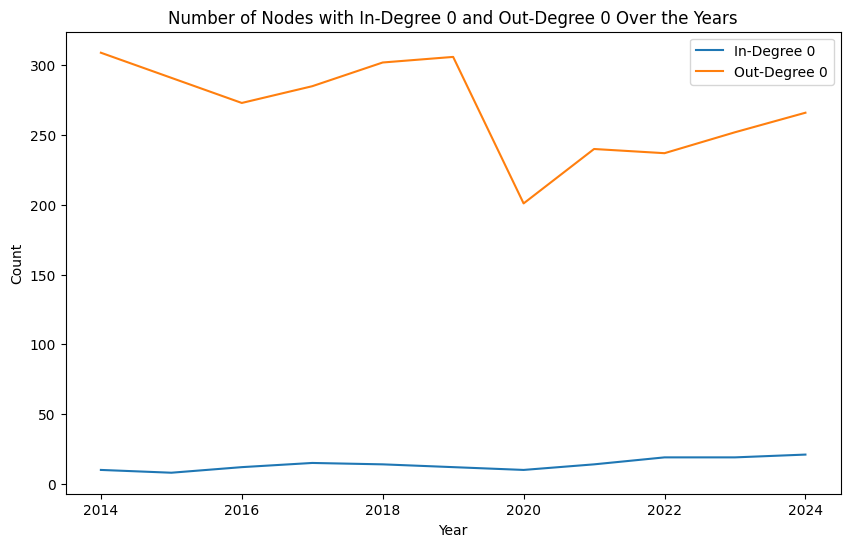

In [ ]:
## compute the number of nodes with in degree 0 and out degree 0 for each year
for key in sorted_keys:
    G_i = graphs[key]
    in_degrees = G_i.in_degree()
    out_degrees = G_i.out_degree()
    in_zero = sum(1 for node, degree in in_degrees if degree == 0)
    out_zero = sum(1 for node, degree in out_degrees if degree == 0)
    print(f"Year: {key.split('_')[1]}, Nodes with In-Degree 0: {in_zero}, Nodes with Out-Degree 0: {out_zero}")

# plot the number of nodes with in degree 0 and out degree 0 over the years
in_zero_counts = []
out_zero_counts = []
for key in sorted_keys:
    G_i = graphs[key]
    in_degrees = G_i.in_degree()
    out_degrees = G_i.out_degree()
    in_zero = sum(1 for node, degree in in_degrees if degree == 0)
    out_zero = sum(1 for node, degree in out_degrees if degree == 0)
    in_zero_counts.append(in_zero)
    out_zero_counts.append(out_zero)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(years, in_zero_counts, label="In-Degree 0")
ax.plot(years, out_zero_counts, label="Out-Degree 0")
ax.set_xlabel("Year")
ax.set_ylabel("Count")
ax.set_title("Number of Nodes with In-Degree 0 and Out-Degree 0 Over the Years")
ax.legend()
plt.show()

Year: 2014, Number of Strongly Connected Components: 320
Year: 2015, Number of Strongly Connected Components: 300
Year: 2016, Number of Strongly Connected Components: 286
Year: 2017, Number of Strongly Connected Components: 301
Year: 2018, Number of Strongly Connected Components: 318
Year: 2019, Number of Strongly Connected Components: 320
Year: 2020, Number of Strongly Connected Components: 212
Year: 2021, Number of Strongly Connected Components: 257
Year: 2022, Number of Strongly Connected Components: 261
Year: 2023, Number of Strongly Connected Components: 275
Year: 2024, Number of Strongly Connected Components: 291


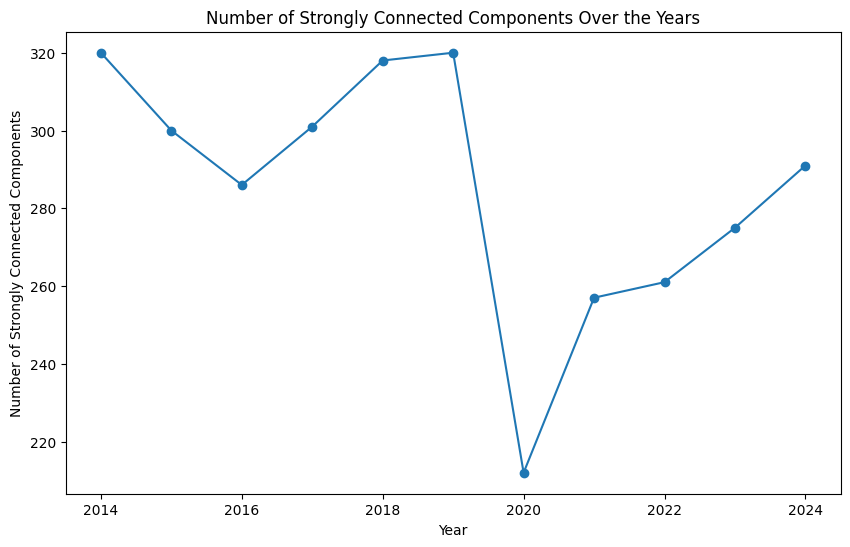

In [ ]:
# compute the number of strongly connected components for each year's graph
for key in sorted_keys:
    G_i = graphs[key]
    scc = list(nx.strongly_connected_components(G_i))
    print(f"Year: {key.split('_')[1]}, Number of Strongly Connected Components: {len(scc)}")

# plot the number of strongly connected components over the years
scc_counts = []
for key in sorted_keys:
    G_i = graphs[key]
    scc = list(nx.strongly_connected_components(G_i))
    scc_counts.append(len(scc))
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(years, scc_counts, marker='o')
ax.set_xlabel("Year")
ax.set_ylabel("Number of Strongly Connected Components")
ax.set_title("Number of Strongly Connected Components Over the Years")
plt.show()